# Agreement Grid Search

In this notebook, we search for the highest adjusted mutual information score, indicating the most in agreement models.

In [1]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import product
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import dbcv
warnings.filterwarnings("ignore")


CLUSTER_SIZE_RANGE = range(2,10)
SAMPLE_MIN_RANGE = range(2,10)

WINDOW_SIZE = [1]

## With Noise as a Cluster

In [3]:
path = Path("../explorer/fingerprints")

resnet_version_param = [18, 50]
latent_space_dim_param = [1, 2, 3]
window_size_param = [1]
training_steps_param = [30, 60, 90, 120]
train_test_split_param = [0, 0.1, 0.5]
line_width_param = [1]

parameters = product(resnet_version_param, latent_space_dim_param, window_size_param, 
                     training_steps_param, train_test_split_param, line_width_param)


parameters = list(parameters)
num_models = len(parameters)


ami_results = np.zeros([len(CLUSTER_SIZE_RANGE), len(SAMPLE_MIN_RANGE)])
DBCV_results = np.zeros([len(CLUSTER_SIZE_RANGE), len(SAMPLE_MIN_RANGE)])

for a, cluster_size in enumerate(CLUSTER_SIZE_RANGE):
    for b, sample_min in enumerate(SAMPLE_MIN_RANGE):
        clusters = []
        num_clusters_per_model = []
        dbcv_score = []


        for resnet_version, latent_space_dim, window_size, training_steps, train_test_split, line_width in parameters:
            model = f"resnet{resnet_version}_latent{latent_space_dim}_window{window_size}eV_steps{training_steps}_split{train_test_split * 10}_width{line_width}_.csv"
            model_path = path / model
            csv = pd.read_csv(model_path)

            x = csv.filter(like="z").to_numpy()

            clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
                        gen_min_span_tree=True, leaf_size=40, metric='minkowski', 
                        cluster_selection_method='leaf', min_cluster_size=cluster_size, 
                        min_samples=sample_min, p=0.2)

            clusterer.fit(x)
            labels = clusterer.labels_
            clusters.append(labels)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = np.sum(labels == -1)

            cluster_info = {"n_clusters": n_clusters, "n_noise": n_noise}
            num_clusters_per_model.append(cluster_info)

            duplicates = pd.DataFrame(x).duplicated(keep=False)
            try:
                dbcv_score.append(dbcv.dbcv(x, labels))
            except:
                dbcv_score.append(0)


        rand_scores_noised = np.zeros([num_models, num_models])
        ami_scores_noised = np.zeros([num_models, num_models])

        for i in range(num_models):
            for j in range(i, num_models): 
                rand_score = adjusted_rand_score(clusters[i], clusters[j])
                rand_scores_noised[i, j] = rand_score
                rand_scores_noised[j, i] = rand_score  

                ami_score = adjusted_mutual_info_score(clusters[i], clusters[j])
                ami_scores_noised[i, j] = ami_score
                ami_scores_noised[j, i] = ami_score  

        ami_no_diag = ami_scores_noised.copy()
        np.fill_diagonal(ami_no_diag, np.nan)

        row_means = np.nanmean(ami_no_diag, axis=1)
        best_model_index = np.nanargmax(row_means)
        ami_results[a, b] = row_means[best_model_index]

        DBCV_results[a, b] = np.nanmax(dbcv_score)
        print(a, b, np.nanmax(dbcv_score), np.nanargmax(dbcv_score))


0 0 0.32509229067853634 67
0 1 0.24059374366840477 67
0 2 0.1969094152724061 67
0 3 0.1592086200993018 67
0 4 0.13014456016294557 61
0 5 0.09806778611584795 40
0 6 0.08191430216076585 26
0 7 0.06830429487410171 43
1 0 0.3206887503864174 67
1 1 0.20473579119150193 67
1 2 0.16578627103987928 67
1 3 0.13726984662893083 67
1 4 0.13014456016294557 61
1 5 0.09388227424982738 40
1 6 0.09030140862354237 41
1 7 0.14179270107835565 70
2 0 0.25293895589729154 67
2 1 0.18958986508700326 67
2 2 0.15321926402758654 67
2 3 0.1269652563662255 61
2 4 0.11066405211454637 61
2 5 0.09511998016969546 67
2 6 0.08893826827647172 41
2 7 0.14179270107835565 70
3 0 0.20400406348873726 67
3 1 0.17016793883725012 67
3 2 0.1513864624233836 67
3 3 0.12092741316060195 61
3 4 0.10333804478853903 61
3 5 0.10626811080549127 41
3 6 0.10364280554740633 26
3 7 0.14179270107835565 70
4 0 0.19394568737946274 67
4 1 0.16191178569923798 67
4 2 0.14472435792179686 67
4 3 0.11055029072592532 61
4 4 0.21676306389602243 21
4 5 0.

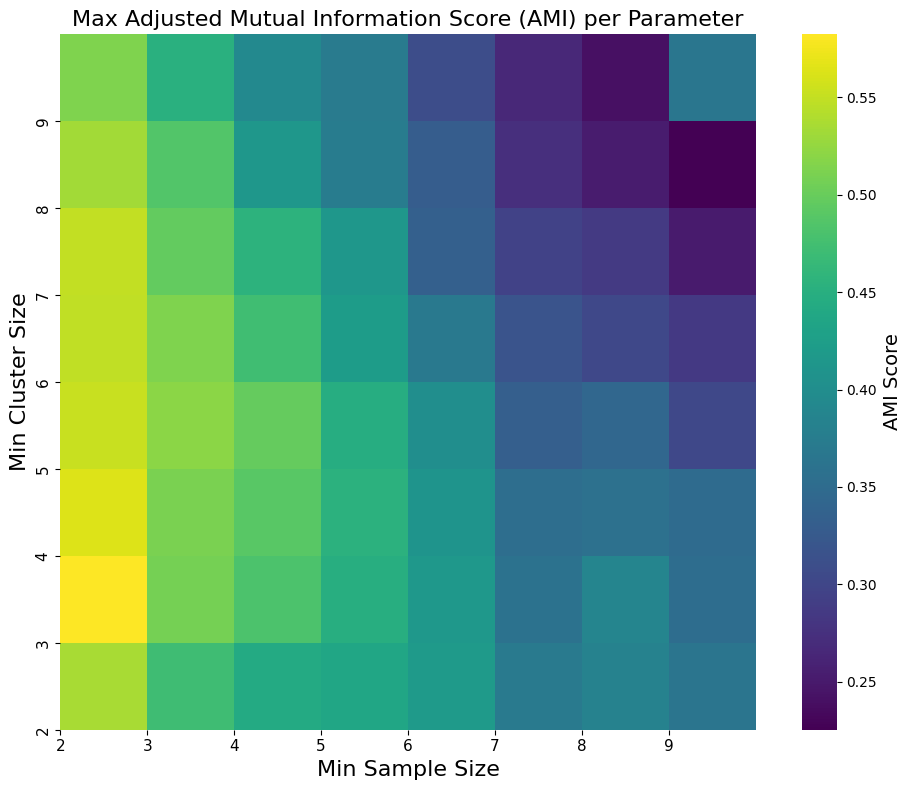

In [ ]:
# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(ami_results, annot=False, cmap="viridis", square=True, cbar_kws={"label": "AMI Score"})

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(14)

# Set title and labels
plt.title("Max Adjusted Mutual Information Score (AMI) per Parameter", fontsize=16)
plt.xlabel("Min Sample Size", fontsize=16)
plt.ylabel("Min Cluster Size",fontsize=16)

# Set tick positions and labels
ax.set_xticks(np.arange(len(SAMPLE_MIN_RANGE)))
ax.set_xticklabels(SAMPLE_MIN_RANGE,fontsize=11)

ax.set_yticks(np.arange(len(CLUSTER_SIZE_RANGE)))
ax.set_yticklabels(CLUSTER_SIZE_RANGE, fontsize=11)


ax.invert_yaxis()
plt.tight_layout()

plt.savefig("heatmap_AMI", dpi=300)
plt.show()


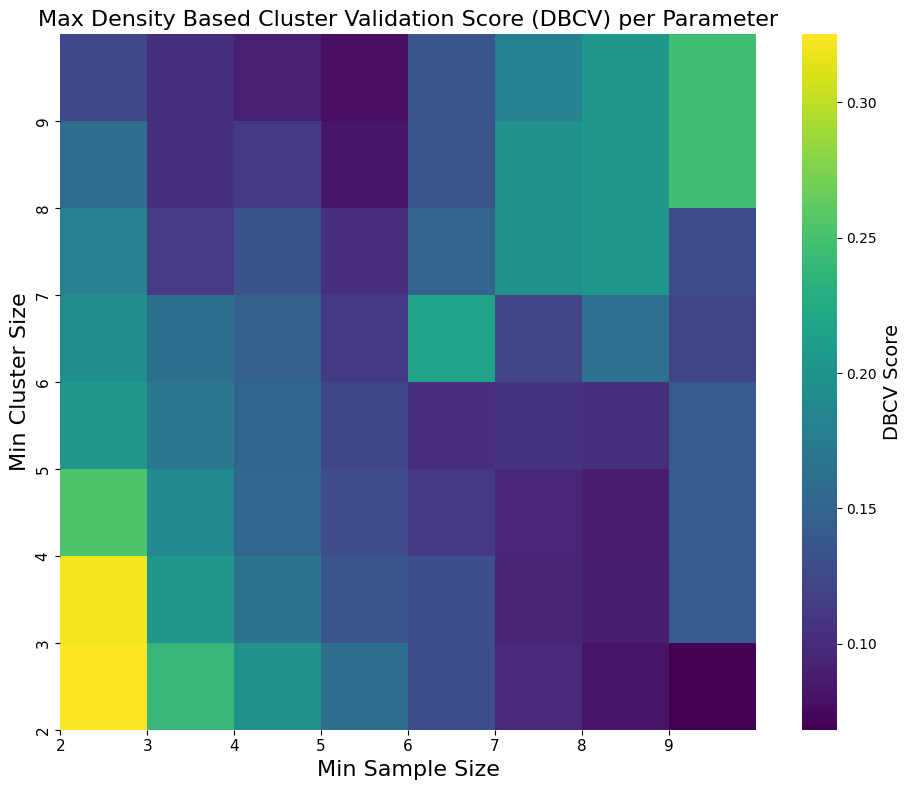

In [ ]:
# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(DBCV_results, annot=False, cmap="viridis", square=True, cbar_kws={"label": "DBCV Score"})

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(14)

# Set title and labels
plt.title("Max Density Based Cluster Validation Score (DBCV) per Parameter", fontsize=16)
plt.xlabel("Min Sample Size", fontsize=16)
plt.ylabel("Min Cluster Size",fontsize=16)

# Set tick positions and labels
ax.set_xticks(np.arange(len(SAMPLE_MIN_RANGE)))
ax.set_xticklabels(SAMPLE_MIN_RANGE,fontsize=11)

ax.set_yticks(np.arange(len(CLUSTER_SIZE_RANGE)))
ax.set_yticklabels(CLUSTER_SIZE_RANGE, fontsize=11)

ax.invert_yaxis()
plt.tight_layout()
plt.savefig("heatmap_all_DBCV", dpi=300)

plt.show()



Using EOM instead of Leaf

In [ ]:
path = Path("../explorer/fingerprints")

resnet_version_param = [18, 50]
latent_space_dim_param = [1, 2, 3]
window_size_param = [1]
training_steps_param = [30, 60, 90, 120]
train_test_split_param = [0, 0.1, 0.5]
line_width_param = [1]

parameters = product(resnet_version_param, latent_space_dim_param, window_size_param, 
                     training_steps_param, train_test_split_param, line_width_param)


parameters = list(parameters)
num_models = len(parameters)


ami_results = np.zeros([len(CLUSTER_SIZE_RANGE), len(SAMPLE_MIN_RANGE)])
DBCV_results = np.zeros([len(CLUSTER_SIZE_RANGE), len(SAMPLE_MIN_RANGE)])

for a, cluster_size in enumerate(CLUSTER_SIZE_RANGE):
    for b, sample_min in enumerate(SAMPLE_MIN_RANGE):
        clusters = []
        num_clusters_per_model = []
        dbcv_score = []


        for resnet_version, latent_space_dim, window_size, training_steps, train_test_split, line_width in parameters:
            model = f"resnet{resnet_version}_latent{latent_space_dim}_window{window_size}eV_steps{training_steps}_split{train_test_split * 10}_width{line_width}_.csv"
            model_path = path / model
            csv = pd.read_csv(model_path)

            x = csv.filter(like="z").to_numpy()

            clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
                        gen_min_span_tree=True, leaf_size=40, metric='minkowski', 
                        cluster_selection_method='eom', min_cluster_size=cluster_size, 
                        min_samples=sample_min, p=0.2)

            clusterer.fit(x)
            labels = clusterer.labels_
            clusters.append(labels)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = np.sum(labels == -1)

            cluster_info = {"n_clusters": n_clusters, "n_noise": n_noise}
            num_clusters_per_model.append(cluster_info)

            duplicates = pd.DataFrame(x).duplicated(keep=False)
            try:
                dbcv_score.append(dbcv.dbcv(x, labels))
            except:
                dbcv_score.append(0)


        rand_scores_noised = np.zeros([num_models, num_models])
        ami_scores_noised = np.zeros([num_models, num_models])

        for i in range(num_models):
            for j in range(i, num_models): 
                rand_score = adjusted_rand_score(clusters[i], clusters[j])
                rand_scores_noised[i, j] = rand_score
                rand_scores_noised[j, i] = rand_score  

                ami_score = adjusted_mutual_info_score(clusters[i], clusters[j])
                ami_scores_noised[i, j] = ami_score
                ami_scores_noised[j, i] = ami_score  

        ami_no_diag = ami_scores_noised.copy()
        np.fill_diagonal(ami_no_diag, np.nan)

        row_means = np.nanmean(ami_no_diag, axis=1)
        best_model_index = np.nanargmax(row_means)
        ami_results[a, b] = row_means[best_model_index]

        DBCV_results[a, b] = np.nanmax(dbcv_score)
        print(a, b, np.nanmax(dbcv_score), np.nanargmax(dbcv_score))


In [ ]:
# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(ami_results, annot=False, cmap="viridis", square=True, cbar_kws={"label": "AMI Score"})

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(14)

# Set title and labels
plt.title("Max Adjusted Mutual Information Score (AMI) per Parameter", fontsize=16)
plt.xlabel("Min Sample Size", fontsize=16)
plt.ylabel("Min Cluster Size",fontsize=16)

# Set tick positions and labels
ax.set_xticks(np.arange(len(SAMPLE_MIN_RANGE)))
ax.set_xticklabels(SAMPLE_MIN_RANGE,fontsize=11)

ax.set_yticks(np.arange(len(CLUSTER_SIZE_RANGE)))
ax.set_yticklabels(CLUSTER_SIZE_RANGE, fontsize=11)


ax.invert_yaxis()
plt.tight_layout()

plt.savefig("heatmap_AMI", dpi=300)
plt.show()


In [ ]:
# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(DBCV_results, annot=False, cmap="viridis", square=True, cbar_kws={"label": "DBCV Score"})

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(14)

# Set title and labels
plt.title("Max Density Based Cluster Validation Score (DBCV) per Parameter", fontsize=16)
plt.xlabel("Min Sample Size", fontsize=16)
plt.ylabel("Min Cluster Size",fontsize=16)

# Set tick positions and labels
ax.set_xticks(np.arange(len(SAMPLE_MIN_RANGE)))
ax.set_xticklabels(SAMPLE_MIN_RANGE,fontsize=11)

ax.set_yticks(np.arange(len(CLUSTER_SIZE_RANGE)))
ax.set_yticklabels(CLUSTER_SIZE_RANGE, fontsize=11)

ax.invert_yaxis()
plt.tight_layout()
plt.savefig("heatmap_all_DBCV", dpi=300)

plt.show()



## Without Noise

In [2]:
def filtered_rand_ami(labels1, labels2):
    mask = (labels1 != -1) & (labels2 != -1)
    if np.sum(mask) == 0:
        return np.nan, np.nan
    l1 = labels1[mask]
    l2 = labels2[mask]
    rand = adjusted_rand_score(l1, l2)
    ami = adjusted_mutual_info_score(l1, l2)
    return rand, ami


path = Path("../explorer/fingerprints")

resnet_version_param = [18, 50]
latent_space_dim_param = [1, 2, 3]
window_size_param = [1]
training_steps_param = [30, 60, 90, 120]
train_test_split_param = [0, 0.1, 0.5]
line_width_param = [1]

parameters = product(resnet_version_param, latent_space_dim_param, window_size_param, 
                     training_steps_param, train_test_split_param, line_width_param)


parameters = list(parameters)
num_models = len(parameters)


ami_results = np.zeros([len(CLUSTER_SIZE_RANGE), len(SAMPLE_MIN_RANGE)])

for i, cluster_size in enumerate(CLUSTER_SIZE_RANGE):
    for j, sample_min in enumerate(SAMPLE_MIN_RANGE):
        clusters = []
        num_clusters_per_model = []

        for resnet_version, latent_space_dim, window_size, training_steps, train_test_split, line_width in parameters:
            model = f"resnet{resnet_version}_latent{latent_space_dim}_window{window_size}eV_steps{training_steps}_split{train_test_split * 10}_width{line_width}_.csv"
            model_path = path / model
            csv = pd.read_csv(model_path)

            x = csv.filter(like="z").to_numpy()

            clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
                        gen_min_span_tree=True, leaf_size=40, metric='minkowski', 
                        cluster_selection_method='leaf', min_cluster_size=cluster_size, 
                        min_samples=sample_min, p=0.2)

            labels = clusterer.fit_predict(x)
            clusters.append(labels)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = np.sum(labels == -1)

            cluster_info = {"n_clusters": n_clusters, "n_noise": n_noise}
            num_clusters_per_model.append(cluster_info)

        rand_scores = np.zeros([num_models, num_models])
        ami_scores = np.zeros([num_models, num_models])

        for m in range(num_models):
            for n in range(m, num_models):
                rand, ami = filtered_rand_ami(clusters[m], clusters[n])
                rand_scores[m, n] = rand_scores[n, m] = rand
                ami_scores[m, n] = ami_scores[n, m] = ami

        ami_no_diag = ami_scores.copy()
        np.fill_diagonal(ami_no_diag, np.nan)

        row_means = np.nanmean(ami_no_diag, axis=1)
        best_model_index = np.nanargmax(row_means)
        ami_results[i, j] = row_means[best_model_index]

        print(i, j)



0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7


As you can see, using AMI without noise encourages clusters that replace essentially all data with noise, occuring at the large values of min cluster size or min noise. Hence, we used the clustering with noise to evaluate the best model

In [ ]:
max_index = np.unravel_index(np.argmax(ami_results), ami_results.shape)
print(max_index)
print(ami_results[max_index[0], max_index[1]])

# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(ami_results, annot=False, cmap="viridis", square=True, cbar_kws={"label": "AMI Score"})

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(14)

# Set title and labels
plt.title("Max Adjusted Mutual Information Score (AMI) per Parameter", fontsize=16)
plt.xlabel("Min Sample Size", fontsize=16)
plt.ylabel("Min Cluster Size",fontsize=16)

# Set tick positions and labels
ax.set_xticks(np.arange(len(SAMPLE_MIN_RANGE)))
ax.set_xticklabels(SAMPLE_MIN_RANGE,fontsize=11)

ax.set_yticks(np.arange(len(CLUSTER_SIZE_RANGE)))
ax.set_yticklabels(CLUSTER_SIZE_RANGE, fontsize=11)


ax.invert_yaxis()
plt.tight_layout()

plt.savefig("heatmap_AMI", dpi=300)
plt.show()


(np.int64(1), np.int64(4))
0.9557259465898217
